<div style="text-align: right">Peter Norvig, 12 Feb 2016.
Translated to Julia by Mohammed El-Beltagy, 3 Mar 2017</div> 

# A Concrete Introduction to Probability (using Julia)

*This notebook is a Julia translation of [Norvig's Original Notebook](http://nbviewer.ipython.org/url/norvig.com/ipython/Probability.ipynb). Python generators were replaced by Julia's coroutines. When dealing with",
    "changing input types, I used Julia's multiple dispatch instead of checking for",
    "types inside a function. Norvig's description and original text is only",
    "changes when the results are slightly different is some simulations. *\n


This notebook covers the basics of probability theory, with Julia implementations. (You should have some background in [probability](http://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/pdf.html) and [Julia](http://julialang.org/learning/).) 


In 1814, Pierre-Simon Laplace [wrote](https://en.wikipedia.org/wiki/Classical_definition_of_probability):

>*Probability ... is thus simply a fraction whose numerator is the number of favorable cases and whose denominator is the number of all the cases possible ... when nothing leads us to expect that any one of these cases should occur more than any other.*

![Laplace](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/AduC_197_Laplace_%28P.S.%2C_marquis_de%2C_1749-1827%29.JPG/180px-AduC_197_Laplace_%28P.S.%2C_marquis_de%2C_1749-1827%29.JPG)
<center><a href="https://en.wikipedia.org/wiki/Pierre-Simon_Laplace">Pierre-Simon Laplace</a><br>1814</center>


Laplace really nailed it, way back then! If you want to untangle a probability problem, all you have to do is be methodical about defining exactly what the cases are, and then careful in counting the number of favorable and total cases. We'll start being methodical by defining some vocabulary:


- **[Experiment](https://en.wikipedia.org/wiki/Experiment_(probability_theory%29):**
  An occurrence with an uncertain outcome that we can observe.
  <br>*For example, rolling a die.*
- **[Outcome](https://en.wikipedia.org/wiki/Outcome_(probability%29):**
  The result of an experiment; one particular state of the world. What Laplace calls a "case."
  <br>*For example:* `4`.
- **[Sample Space](https://en.wikipedia.org/wiki/Sample_space):**
  The set of all possible outcomes for the experiment. 
  <br>*For example,* `{1, 2, 3, 4, 5, 6}`.
- **[Event](https://en.wikipedia.org/wiki/Event_(probability_theory%29):**
  A subset of possible outcomes that together have some property we are interested in.
  <br>*For example, the event "even die roll" is the set of outcomes* `{2, 4, 6}`. 
- **[Probability](https://en.wikipedia.org/wiki/Probability_theory):**
  As Laplace said, the probability of an event with respect to a sample space is the number of favorable cases (outcomes from the sample space that are in the event) divided by the total number of cases in the sample space. (This assumes that all outcomes in the sample space are equally likely.) Since it is a ratio, probability will always be a number between 0 (representing an impossible event) and 1 (representing a certain event).
<br>*For example, the probability of an even die roll is 3/6 = 1/2.*

This notebook will develop all these concepts; I also have a [second part](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) that covers  paradoxes in Probability Theory.

# Code for `P` 

`P` is the traditional name for the Probability function:

In [1]:
"The probability of an event, given a sample space of equiprobable outcomes."
P(event, space)=length(intersect(event,space))//length(space);

Read this as implementing Laplace's quote directly: *"Probability is thus simply a fraction whose numerator is the number of favorable cases and whose denominator is the number of all the cases possible."* 
 

# Warm-up Problem: Die Roll

What's the probability of rolling an even number with a single six-sided fair die? 

We can define the sample space `D` and the event `even`, and compute the probability:

In [2]:
D = [1, 2, 3, 4, 5, 6];
even = [2, 4, 6]

P(even, D)

1//2

It is good to confirm what we already knew.

You may ask: Why does the definition of `P` use `length(intersect(event,space))` rather than `length(event)`? Because I don't want to count outcomes that were specified in `event` but aren't actually in the sample space. Consider:

In [3]:
even = [2, 4, 6, 8, 10, 12]

P(even, D)

1//2

Here, `length(event)` and `length(space)` are both 6, so if just divided, then `P` would be 1, which is not right.
The favorable cases are the *intersection* of the event and the space, which in Julia is `intersect(event,space)`.
Also note that I use Julia's syntax of `//` for defining rational numbers rather than regular division because I want exact answers like 1/3, not 0.3333333333333333.



# Urn Problems

Around 1700, Jacob Bernoulli wrote about removing colored balls from an urn in his landmark treatise *[Ars Conjectandi](https://en.wikipedia.org/wiki/Ars_Conjectandi)*, and ever since then, explanations of probability have relied on [urn problems](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=probability%20ball%20urn). (You'd think the urns would be empty by now.) 

![Jacob Bernoulli](http://www2.stetson.edu/~efriedma/periodictable/jpg/Bernoulli-Jacob.jpg)
<center><a href="https://en.wikipedia.org/wiki/Jacob_Bernoulli">Jacob Bernoulli</a><br>1700</center>

For example, here is a three-part problem [adapted](http://mathforum.org/library/drmath/view/69151.html)  from mathforum.org:

> An urn contains 23 balls: 8 white, 6 blue, and 9 red.  We select six balls at random (each possible selection is equally likely). What is the probability of each of these possible outcomes:

> 1. all balls are red
2. 3 are blue, 2 are white, and 1 is red
3. exactly 4 balls are white

So, an outcome is a set of 6 balls, and the sample space is the set of all possible 6 ball combinations. We'll solve each of the 3 parts using our `P` function, and also using basic arithmetic; that is, *counting*. Counting is a bit tricky because:
- We have multiple balls of the same color. 
- An outcome is a *set* of balls, where order doesn't matter, not a *sequence*, where order matters.

To account for the first issue, I'll have 8 different white balls labelled `'W1'` through `'W8'`, rather than having eight balls all labelled `'W'`.  That makes it clear that selecting `'W1'` is different from selecting `'W2'`.

The second issue is handled automatically by the `P` function, but if I want to do calculations by hand, I will sometimes first count the number of *permutations* of balls, then get the number of *combinations* by dividing the number of permutations by *c*!, where *c* is the number of balls in a combination. For example, if I want to choose 2 white balls from the 8 available, there are 8 ways to choose a first white ball and 7 ways to choose a second, and therefore 8 &times; 7 = 56 permutations of two white balls. But there are only 56 / 2 = 28 combinations, because `(W1, W2)` is the same combination as `(W2, W1)`.

We'll start by defining the contents of the urn:

In [4]:
"The set of ways of concatenating one item from collection A with one from B."
immutable Ball{TC,TN}
    color::TC
    number::TN
end

Ball

In [5]:
# import Base.string, Base.print,Base.show #So that they print nicely 
# string(b::Ball)="$(b.color)$(b.number)"
# print(io::IO, x::Ball) = print(io, string(x))
Base.show(io::IO, b::Ball) = print(io, "$(b.color)$(b.number)")

In [6]:
"generates a list of balls with color c and and numbers from 1 to n"
labeled_balls(c,n)=[Ball(t[2],t[1]) for t in Base.product(1:n,c)]

labeled_balls

In [7]:
urn = [labeled_balls("W", 8); labeled_balls("B", 6) ; labeled_balls("R", 9)] 

23×1 Array{Ball{Char,Int64},2}:
 W1
 W2
 W3
 W4
 W5
 W6
 W7
 W8
 B1
 B2
 B3
 B4
 B5
 B6
 R1
 R2
 R3
 R4
 R5
 R6
 R7
 R8
 R9

In [8]:
length(urn)

23

Now we can define the sample space, `U6`, as the set of all 6-ball combinations.  We use `Combinatorics` package to generate the combinations, and then join each combination into a string:

In [9]:
using Combinatorics

"All combinations of n items; each combo as a concatenated str."
function combos(items, n)
    combs=combinations(items,n)
    collect(combs)
end


    
U6 = combos(urn, 6)

length(U6)

100947

I don't want to print all 100,947 members of the sample space; let's just peek at a random sample of them:

In [10]:
using StatsBase

sample(U6, 10)

10-element Array{Array{Ball{Char,Int64},1},1}:
 Ball{Char,Int64}[W6,B2,R1,R6,R7,R8]
 Ball{Char,Int64}[B3,B5,B6,R6,R8,R9]
 Ball{Char,Int64}[W1,W5,W7,R2,R6,R9]
 Ball{Char,Int64}[W8,B2,B3,R2,R3,R9]
 Ball{Char,Int64}[W5,W6,W7,W8,B5,R9]
 Ball{Char,Int64}[W2,W3,W6,W7,B6,R5]
 Ball{Char,Int64}[W8,B1,B2,B3,R2,R6]
 Ball{Char,Int64}[W4,W5,B3,R6,R7,R8]
 Ball{Char,Int64}[W1,W4,W6,B1,B5,R7]
 Ball{Char,Int64}[W2,W4,W7,W8,R4,R6]

Is 100,947 really the right number of ways of choosing 6 out of 23 items, or  "23 choose 6", as  mathematicians [call it](https://en.wikipedia.org/wiki/Combination)?  Well, we can choose any of 23 for the first item, any of 22 for the second, and so on down to 18 for the sixth. But we don't care about the ordering of the six items, so we divide the product by 6! (the number of permutations of 6 things) giving us:

$$23 ~\mbox{choose}~ 6 = \frac{23 \cdot 22 \cdot 21 \cdot 20 \cdot 19 \cdot 18}{6!} = 100947$$

Note that $23 \cdot 22 \cdot 21 \cdot 20 \cdot 19 \cdot 18 = 23! \;/\; 17!$, so, generalizing, we can write:

$$n ~\mbox{choose}~ c = \frac{n!}{(n - c)! \cdot c!}$$

And we can translate that to code and verify that 23 choose 6 is 100,947, in Julia we do that by invoking the `binomial` function:

In [11]:
binomial(23, 6)

100947

Now we're ready to answer the 4 problems: 

### Urn Problem 1: what's the probability of selecting 6 red balls? 

We first define a function for counting the number of occurrences in a string:

In [12]:
"counts the number of balls of color c in list l"
count_ball_color(l,c)=count(x->x.color==c,l)

count_ball_color

In [13]:
red6 = [s for s in U6 if count_ball_color(s,'R') == 6]

P(red6, U6)

4//4807

Let's investigate a bit more. How many ways of getting 6 red balls are there?

In [14]:
length(red6)

84

Why are there 84 ways?  Because there are 9 red balls in the urn, and we are asking how many ways we can choose 6 of them:

In [15]:
binomial(9, 6)

84

So the probabilty of 6 red balls is then just 9 choose 6 divided by the size of the sample space:

In [16]:
P(red6, U6) == binomial(9, 6)//length(U6)

true

### Urn Problem 2: what is the probability of 3 blue, 2 white, and 1 red?

In [17]:
b3w2r1 = [s for s in U6 if
    count_ball_color(s,'B') == 3 && count_ball_color(s,'W') == 2 && count_ball_color(s,'R') == 1]

P(b3w2r1, U6)

240//4807

We can get the same answer by counting how many ways we can choose 3 out of 6 blues, 2 out of 8 whites, and 1 out of 9 reds, and dividing by the number of possible selections:

In [18]:
P(b3w2r1, U6) == binomial(6, 3) * binomial(8, 2) * binomial(9, 1)//
                                      length(U6)

true

Here we don't need to divide by any factorials, because `choose` has already accounted for that. 

We can get the same answer by figuring: "there are 6 ways to pick the first blue, 5 ways to pick the second blue, and 4 ways to pick the third; then 8 ways to pick the first white and 7 to pick the second; then 9 ways to pick a red. But the order `'B1, B2, B3'` should count as the same as `'B2, B3, B1'` and all the other orderings; so divide by 3! to account for the permutations of blues, by 2! to account for the permutations of whites, and by 100947 to get a probability:

In [19]:
 P(b3w2r1, U6) == (6 * 5 * 4) * (8 * 7) * 9//
                           (factorial(3) * factorial(2) * length(U6))

true

### Urn Problem 3: What is the probability of exactly 4 white balls?

We can interpret this as choosing 4 out of the 8 white balls, and 2 out of the 15 non-white balls. Then we can solve it the same three ways:

In [20]:
w4 = [s for s in U6 if
    count_ball_color(s,'W') == 4]

P(w4, U6)

350//4807

In [21]:
P(w4, U6) == binomial(8, 4) * binomial(15, 2)//
                         length(U6)

true

In [22]:
P(w4, U6) == (8 * 7 * 6 * 5) * (15 * 14)//
                     (factorial(4) * factorial(2) * length(U6))

true

# Revised Version of `P`, with more general events

To calculate the probability of an even die roll, I originally said

    even = {2, 4, 6}
    
But that's inelegant&mdash;I had to explicitly enumerate all the even numbers from one to six. If I ever wanted to deal with a twelve or twenty-sided die, I would have to go back and change  `even`.  I would prefer to define `even` once and for all like this:

In [23]:
even_p(n) = (n % 2 == 0);

Now in order to make `P(even, D)` work, I'll have to modify `P` to accept an event as either
a *set* of outcomes (as before), or a *predicate* over outcomes&mdash;a function that returns true for an outcome that is in the event:

In [24]:
"""The probability of an event, given a sample space of equiprobable outcomes.
event can be either a set of outcomes, or a predicate (true for outcomes in the event)."""
#Making use of Julia's multiple dispatch
function P(event::Function, space)
    count(event,space)//length(space) #Converting the space to a Set speeds the intersection
end

"The subset of elements in the collection for which the predicate is true."
function such_that(predicate::Function, collection)
    filter(predicate,collection)
end;

Here we see how `such_that`, the new `even` predicate, and the new `P` work:

In [25]:
such_that(even_p, D)

3-element Array{Int64,1}:
 2
 4
 6

In [26]:
P(even_p, D)

1//2

In [27]:
D12 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

such_that(even_p, D12)

6-element Array{Int64,1}:
  2
  4
  6
  8
 10
 12

In [28]:
P(even_p, D12)

1//2

We can now define more interesting events using predicates; for example we can determine the probability that the sum of a three-dice roll is prime (using a definition of `is_prime` that is efficient enough for small `n`):

In [29]:
using Primes
D3 = [(d1, d2, d3) for d1 in D for d2 in D for d3 in D]

prime_sum(outcome)=isprime(sum(outcome))

P(prime_sum, D3)

73//216

# Card Problems

Consider dealing a hand of five playing cards. We can define `deck` as a set of 52 cards, and `Hands` as the sample space of all combinations of 5 cards:

In [30]:
# We start by defining an immutable card type
immutable Card{TS,TR}
   suit :: TS
   rank :: TR
end

In [31]:
#Modifying how the the Card type prints 
Base.show(io::IO, x::Card) = print(io, "$(x.suit)$(x.rank)" )

In [32]:
suits = "SHDC"
ranks = "A23456789TJQK"
deck  = [ Card(s,r) for r in ranks for s in suits ]
length(deck)

52

In [33]:
Hands = combos(deck, 5)

@assert length(Hands) == binomial(52, 5)

sample(Hands, 5)

5-element Array{Array{Card{Char,Char},1},1}:
 Card{Char,Char}[C3,H4,D4,D8,DJ]
 Card{Char,Char}[H4,S5,S7,CT,HK]
 Card{Char,Char}[D3,C5,H6,D7,C9]
 Card{Char,Char}[S2,D4,H6,SK,HK]
 Card{Char,Char}[DA,H7,D8,H9,DQ]

Now we can answer questions like the probability of being dealt a flush (5 cards of the same suit):

In [34]:
count_hand_suit(hand,suit)=count(x->x.suit==suit,hand)
count_hand_rank(hand,rank)=count(x->x.rank==rank,hand)
flush(hand)=any(count_hand_suit(hand,suit) == 5 for suit in suits)

P(flush, Hands)

33//16660

Or the probability of four of a kind:

In [35]:
four_kind(hand)=any(count_hand_rank(hand,rank) == 4 for rank in ranks)

P(four_kind, Hands)

1//4165

# Fermat and Pascal: Gambling, Triangles, and the Birth of Probability

<table>
<tr><td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Pierre_de_Fermat2.png/140px-Pierre_de_Fermat2.png"><center><a href="https://en.wikipedia.org/wiki/Pierre_de_Fermat">Pierre de Fermat</a><br>1654
<td><img src="https://www.umass.edu/wsp/images/pascal.jpg"><center><a href="https://en.wikipedia.org/wiki/Blaise_Pascal">Blaise Pascal]</a><br>1654
</table>

Consider a gambling game consisting of tossing a coin. Player H wins the game if 10 heads come up, and T wins if 10 tails come up. If the game is interrupted when H has 8 heads and T has 7 tails, how should the pot of money (which happens to be 100 Francs) be split?
In 1654, Blaise Pascal and Pierre de Fermat corresponded on this problem, with Fermat [writing](http://mathforum.org/isaac/problems/prob1.html):

>Dearest Blaise,

>As to the problem of how to divide the 100 Francs, I think I have found a solution that you will find to be fair. Seeing as I needed only two points to win the game, and you needed 3, I think we can establish that after four more tosses of the coin, the game would have been over. For, in those four tosses, if you did not get the necessary 3 points for your victory, this would imply that I had in fact gained the necessary 2 points for my victory. In a similar manner, if I had not achieved the necessary 2 points for my victory, this would imply that you had in fact achieved at least 3 points and had therefore won the game. Thus, I believe the following list of possible endings to the game is exhaustive. I have denoted 'heads' by an 'h', and tails by a 't.' I have starred the outcomes that indicate a win for myself.

    h h h h *       h h h t *       h h t h *       h h t t *
    h t h h *       h t h t *       h t t h *       h t t t
    t h h h *       t h h t *       t h t h *       t h t t
    t t h h *       t t h t         t t t h         t t t t

>I think you will agree that all of these outcomes are equally likely. Thus I believe that we should divide the stakes by the ration 11:5 in my favor, that is, I should receive (11/16)*100 = 68.75 Francs, while you should receive 31.25 Francs.

>I hope all is well in Paris,

>Your friend and colleague,

>Pierre

Pascal agreed with this solution, and [replied](http://mathforum.org/isaac/problems/prob2.html) with a generalization that made use of his previous invention, Pascal's Triangle. There's even [a book](https://smile.amazon.com/Unfinished-Game-Pascal-Fermat-Seventeenth-Century/dp/0465018963?sa-no-redirect=1) about it.

We can solve the problem with the tools we have:

In [36]:
"The probability that H will win the unfinished game, given the number of points needed by H and T to win."
function win_unfinished_game(Hneeds, Tneeds)
    Hwins(outcome)=count(x->x=='h',outcome)>= Hneeds
    P(Hwins, continuations(Hneeds, Tneeds))
end

"All continuations of a game where H needs `Hneeds` points to win and T needs `Tneeds`."
function continuations(Hneeds, Tneeds)
    rounds = ["ht" for _ in 1:(Hneeds + Tneeds - 1)]
    p=Base.product(rounds...)
    reshape(collect(p),length(p),1)
end

continuations

In [37]:
continuations(2, 3)

16×1 Array{Tuple{Char,Char,Char,Char},2}:
 ('h','h','h','h')
 ('t','h','h','h')
 ('h','t','h','h')
 ('t','t','h','h')
 ('h','h','t','h')
 ('t','h','t','h')
 ('h','t','t','h')
 ('t','t','t','h')
 ('h','h','h','t')
 ('t','h','h','t')
 ('h','t','h','t')
 ('t','t','h','t')
 ('h','h','t','t')
 ('t','h','t','t')
 ('h','t','t','t')
 ('t','t','t','t')

In [38]:
win_unfinished_game(2, 3)

11//16

Our answer agrees with Pascal and Fermat; we're in good company!

# Non-Equiprobable Outcomes: Probability Distributions

So far, we have made the assumption that every outcome in a sample space is equally likely. In real life, we often get outcomes that are not equiprobable. For example, the probability of a child being a girl is not exactly 1/2, and the probability is slightly different for a second child. An [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) gives the following counts for two-child families in Denmark, where `GB` means a family where the first child is a girl and the second a boy:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138
    
We will introduce three more definitions:

* [Frequency](https://en.wikipedia.org/wiki/Frequency_%28statistics%29): a number describing how often an outcome occurs. Can be a count like 121801, or a ratio like 0.515.

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): A mapping from outcome to frequency for each outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): A distribution that has been *normalized* so that the sum of the frequencies is 1.

We define `ProbDist` to take the same kinds of arguments that `dict` does: either a mapping or an iterable of `(key, val)` pairs, and/or optional keyword arguments. 

In [39]:
type ProbDist
    dict::Dict{String,Float64}
    function ProbDist(ps::Array{Pair{String,Float64},1})
        n=length(ps)
        probs=Vector{Float64}(n)
        vals=[x[2] for x in ps]
        tot=sum(vals)
        map!(x->x/tot,probs,vals)
        @assert all(probs.>=0)
        new(Dict((ps[i][1],probs[i]) for i in 1:n))
    end
    function ProbDist(;l...)
        ProbDist([Pair(string(x[1]),float(x[2])) for x in l])
    end
end

Doing multiple dispatch on `getindex` to easily get the proability of an event.

In [40]:
import Base.getindex
getindex(ProbDist,i)=ProbDist.dict[i];

We also need to modify the functions `P` and `such_that` to accept either a sample space  or a probability distribution as the second argument.

In [41]:
"""The probability of an event, given a sample space of equiprobable outcomes. 
event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
function P(event, space::ProbDist) 
    sum(space[o] for o in keys(space.dict) if o in event)
end

function P(event::Function, space::ProbDist) 
    sum(space[o] for o in keys(space.dict) if event(o))
end
                
function such_that(event::Function, space::ProbDist) 
    ProbDist([Pair(i,space[i]) for i in filter(event, keys(space.dict))])
end

such_that (generic function with 2 methods)

Modifying how a `ProbDist` gets printed

In [42]:
Base.show(io::IO, p::ProbDist) =print(io,"ProbDist: "*join(("$(x[1])=$(round(x[2],4))" for x in p.dict ),", "))

Here is the probability distribution for Danish two-child families:

In [43]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)

ProbDist: BB=0.2645, BG=0.2488, GG=0.2384, GB=0.2483

And here are some predicates that will allow us to answer some questions:

In [44]:
first_girl(outcome)= outcome[1] == 'G'
first_boy(outcome) =  outcome[1] == 'B'
second_girl(outcome)= outcome[2] == 'G'
second_boy(outcome)= outcome[2] == 'B'
two_girls(outcome)= outcome    == "GG"

two_girls (generic function with 1 method)

In [45]:
P(first_girl, DK)

0.4866706335070131

In [46]:
P(second_girl, DK)

0.4872245557856497

The above says that the probability of a girl is somewhere between 48% and 49%, but that it is slightly different between the first or second child.

In [47]:
P(second_girl, such_that(first_girl, DK)), P(second_girl, such_that(first_boy, DK))

(0.4898669165584115,0.48471942072973107)

In [48]:
P(second_boy, such_that(first_girl, DK)), P(second_boy, such_that(first_boy, DK))

(0.5101330834415885,0.5152805792702689)

The above says that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

# More Urn Problems: M&Ms and Bayes

Here's another urn problem (or "bag" problem) [from](http://allendowney.blogspot.com/2011/10/my-favorite-bayess-theorem-problems.html) prolific Python/Probability author [Allen Downey ](http://allendowney.blogspot.com/):

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag?

To solve this problem, we'll first represent probability distributions for each bag: `bag94` and `bag96`:

In [49]:
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
bag96 = ProbDist(blue=24, green=20, orange=16, yellow=14, red=13, brown=13);

Next, define `MM` as the joint distribution&mdash;the sample space for picking one M&M from each bag. The outcome `'yellow green'` means that a yellow M&M was selected from the 1994 bag and a green one from the 1996 bag.

In [50]:
"""The joint distribution of two independent probability distributions. 
Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
function joint(A, B, sep="")
    ProbDist([Pair(a[1] * sep * b[1], a[2] * b[2])
        for a in A.dict for b in B.dict])
end

MM = joint(bag94, bag96, " ")
MM.dict

Dict{String,Float64} with 36 entries:
  "red orange"    => 0.032
  "green blue"    => 0.024
  "yellow yellow" => 0.028
  "tan green"     => 0.02
  "brown blue"    => 0.072
  "orange brown"  => 0.013
  "green green"   => 0.02
  "green red"     => 0.013
  "orange red"    => 0.013
  "orange blue"   => 0.024
  "brown brown"   => 0.039
  "orange yellow" => 0.014
  "brown green"   => 0.06
  "yellow green"  => 0.04
  "tan red"       => 0.013
  "yellow brown"  => 0.026
  "yellow blue"   => 0.048
  "tan brown"     => 0.013
  "green yellow"  => 0.014
  "green orange"  => 0.016
  "brown red"     => 0.039
  "tan orange"    => 0.016
  "tan blue"      => 0.024
  "yellow orange" => 0.032
  "red brown"     => 0.026
  ⋮               => ⋮

First we'll look at the "One is yellow and one is green" part:

In [51]:
yellow_and_green(outcome)= contains(outcome,"yellow") && contains(outcome,"green")

such_that(yellow_and_green, MM)

ProbDist: green yellow=0.2593, yellow green=0.7407

Now we can answer the question: given that we got a yellow and a green (but don't know which comes from which bag), what is the probability that the yellow came from the 1994 bag?

In [52]:
yellow94(outcome)= startswith(outcome,"yellow")

P(yellow94, such_that(yellow_and_green, MM))

0.7407407407407408

So there is a 74% chance that the yellow comes from the 1994 bag.

Answering this question was straightforward: just like all the other probability problems, we simply create a sample space, and use `P` to pick out the probability of the event in question, given what we know about the outcome.
But in a sense it is curious that we were able to solve this problem with the same methodology as the others: this problem comes from a section titled **My favorite Bayes's Theorem Problems**, so one would expect that we'd need to invoke Bayes Theorem to solve it.  The computation above shows that that is not necessary. 

![Bayes](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)
<center><a href="https://en.wikipedia.org/wiki/Thomas_Bayes">Rev. Thomas Bayes</a><br>1701-1761
</center>

Of course, we *could* solve it using Bayes Theorem. Why is Bayes Theorem recommended? Because we are asked about the probability of an event given the evidence, which is not immediately available; however the probability of the evidence given the event is.  

Before we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
Then we get some evidence:
    
    E: first M&M yellow, second green
    
We want to know the probability of hypothesis `A`, given the evidence:
    
    P(A | E)
    
That's not easy to calculate (except by enumerating the sample space). But Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the right-hand-side are easier to calculate:
    
    P(E | A) = 0.20 * 0.20 = 0.04
    P(E | B) = 0.10 * 0.14 = 0.014
    P(A)     = 0.5
    P(B)     = 0.5
    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027
    
And we can get a final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407
             
You have a choice: Bayes Theorem allows you to do less calculation at the cost of more algebra; that is a great trade-off if you are working with pencil and paper. Enumerating the state space allows you to do less algebra at the cost of more calculation; often a good trade-off if you have a computer. But regardless of the approach you use, it is important to understand Bayes theorem and how it works.

There is one important question that Allen Downey does not address: *would you  eat twenty-year-old M&Ms*?
&#128552;

# Newton's Answer to a Problem by Pepys

<table>
<tr><td><img src="http://scienceworld.wolfram.com/biography/pics/Newton.jpg"><center><a href="https://en.wikipedia.org/wiki/Isaac_Newton">Isaac Newton</a><br>1693</center>
<td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Samuel_Pepys_portrait.jpg/148px-Samuel_Pepys_portrait.jpg"><center><a href="https://en.wikipedia.org/wiki/Samuel_Pepys">Samuel Pepys</a><br>1693</center>
</table>

[This paper](http://fermatslibrary.com/s/isaac-newton-as-a-probabilist) explains how  Samuel Pepys wrote to Isaac Newton in 1693 to pose the problem:

> Which of the following three propositions has the greatest chance of success? 
  1. Six fair dice are tossed independently and at least one “6” appears. 
  2. Twelve fair dice are tossed independently and at least two “6”s appear. 
  3. Eighteen fair dice are tossed independently and at least three “6”s appear.
  
Newton was able to answer the question correctly (although his reasoning was not quite right); let's see how we can do. Since we're only interested in whether a die comes up as "6" or not, we can define a single die and the joint distribution over *n* dice as follows:

In [53]:
die = ProbDist([Pair("6",1/6), Pair("-",5/6)])

"Joint probability from tossing n dice."
function dice(n, die)
    if n == 1
        return die
    else
        return joint(die, dice(n - 1, die))
    end
end

dice

In [54]:
dice(3, die).dict

Dict{String,Float64} with 8 entries:
  "666" => 0.00462963
  "6--" => 0.115741
  "66-" => 0.0231481
  "--6" => 0.115741
  "-66" => 0.0231481
  "-6-" => 0.115741
  "---" => 0.578704
  "6-6" => 0.0231481

Now we are ready to determine which proposition is more likely to have the required number of sixes:

In [55]:
at_least(k, result)=  s->count(x->x==result,s) >= k

at_least (generic function with 1 method)

In [56]:
P(at_least(1, '6'), dice(6, die))

0.665102023319616

In [57]:
P(at_least(2, '6'), dice(12, die))

0.618667373732316

In [58]:
P(at_least(3, '6'), dice(18, die))

0.597345685947433

We reach the same conclusion Newton did, that the best chance is rolling six dice.

<hr>

# Simulation

Sometimes it is inconvenient to explicitly define a sample space. Perhaps the sample space is infinite, or perhaps it is just very large and complicated, and we feel more confident in writing a program to *simulate* one pass through all the complications, rather than try to *enumerate* the complete sample space. *Random sampling* from the simulation
can give an accurate estimate of the probability.

# Simulating Monopoly

![](http://buckwolf.org/a.abcnews.com/images/Entertainment/ho_hop_go_050111_t.jpg)<center>[Mr. Monopoly](https://en.wikipedia.org/wiki/Rich_Uncle_Pennybags)<br>1940&mdash;

Consider [problem 84](https://projecteuler.net/problem=84) from the excellent [Project Euler](https://projecteuler.net), which asks for the probability that a player in the game Monopoly ends a roll on each of the squares on the board.  To answer this we need to take into account die rolls, chance and community chest cards, and going to jail (from the "go to jail" space, from a card, or from rolling doubles three times in a row). We do not need to take into account anything about buying or selling properties or exchanging money or winning or losing the game, because these don't change a player's location. We will assume that a player in jail will always pay to get out of jail immediately. 

A game of Monopoly can go on forever, so the sample space is infinite. But even if we limit the sample space to say, 1000 rolls, there are $21^{1000}$ such sequences of rolls (and even more possibilities when we consider drawing cards). So it is infeasible to explicitly represent the sample space.

But it is fairly straightforward to implement a simulation and run it for, say, 400,000 rolls (so the average square will be landed on 10,000 times).  Here is the code for a simulation:

In [59]:
# The board: a list of the names of the 40 squares
board = """GO   A1 CC1 A2  T1 R1 B1  CH1 B2 B3
           JAIL C1 U1  C2  C3 R2 D1  CC2 D2 D3 
           FP   E1 CH2 E2  E3 R3 F1  F2  U2 F3 
           G2J  G1 G2  CC3 G3 R4 CH3 H1  T2 H2""" |> split

# Lists of 16 community chest and 16 chance cards. See do_card.
CC = append!(["GO", "JAIL"], repeat(["?"],outer=[14]))

CH = append!("GO JAIL C1 E3 H2 R1 R R U -3" |> split,  repeat(["?"],outer=[6]))

"""Simulate given number of steps of monopoly game, 
yielding the name of the current square after each step."""
function monopoly(steps)
    CC_deck = shuffle(CC)
    CH_deck = shuffle(CH)
    doubles = 0
    function monopolyTask()
        here = 1
        for _=1:steps
            d1, d2 = rand(1:6), rand(1:6)
            here=goto(here + d1 + d2)
            doubles = (d1 == d2) ? (doubles + 1): 0
            if doubles == 3 || board[here] == "G2J"  
                here=goto("JAIL")
            elseif startswith(board[here],"CC")
                here=do_card(CC_deck,here)
            elseif startswith(board[here],"CH")
                here=do_card(CH_deck,here)
            end
            produce(board[here])
        end
    end
    Task(monopolyTask)
end

"Go to destination square (a square number). Update 'here'."
function goto(square::Int)
    here = (square-1) % length(board)+1
end

"Go to destination square (a square name). Update 'here'."
function goto(square::AbstractString)
    here = findfirst(board,square)
end

"Take the top card from deck and do what it says."
function do_card(deck,here)
    card = pop!(deck)           # The top card
    unshift!(deck,card)           # Move top card to bottom of deck
    if card == "R"|| card == "U" 
        while !startswith(board[here],card)
            here=goto(here + 1)   # Advance to next railroad or utility
        end
    elseif card == "-3"
        here=goto(here - 3)       # Go back 3 spaces
    elseif card != "?"
        here=goto(card)           # Go to destination named on card
    end
    here
end;

And the results:

In [60]:
results = collect(monopoly(10^6));

I'll show a histogram of the squares, with a dotted red line at the average:

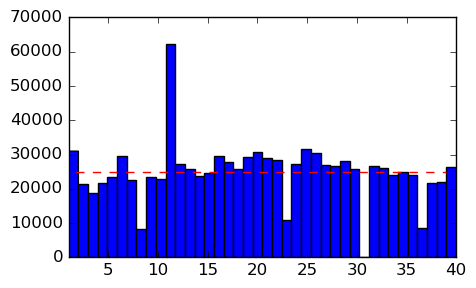

In [61]:
using PyPlot
figure("hist",figsize=(5,3))
ax=axes()
axis([1 ,40, 0 ,70000])
ax[:hist]([findfirst(board,name) for name in results], bins=40);
avg = length(results) / 40
ax[:plot]([0, 39], [avg, avg], "r--");

Another way to see the results:

In [62]:
ProbDist([Pair(String(a[1]),float(a[2])) for a in countmap(results)]).dict

Dict{String,Float64} with 39 entries:
  "F3"   => 0.025876
  "CH1"  => 0.008313
  "C3"   => 0.024583
  "B2"   => 0.023409
  "B1"   => 0.022537
  "B3"   => 0.022865
  "C2"   => 0.023634
  "A2"   => 0.021719
  "U2"   => 0.028006
  "GO"   => 0.030997
  "C1"   => 0.027179
  "CC3"  => 0.024028
  "CH3"  => 0.008686
  "JAIL" => 0.062393
  "G2"   => 0.026166
  "F1"   => 0.027102
  "E1"   => 0.02856
  "FP"   => 0.028952
  "U1"   => 0.02588
  "CH2"  => 0.010861
  "R4"   => 0.024114
  "D2"   => 0.029439
  "CC2"  => 0.025736
  "E3"   => 0.031675
  "R1"   => 0.029541
  ⋮      => ⋮

There is one square far above average: `JAIL`, at a little over 6%. There are four squares far below average: the three chance squares, `CH1`, `CH2`, and `CH3`, at around 1% (because 10 of the 16 chance cards send the player away from the square), and the "Go to Jail" square, square number 30 on the plot, which has a frequency of 0 because you can't end a turn there. The other squares are around 2% to 3% each, which you would expect, because 100% / 40 = 2.5%.

# The Central Limit Theorem / Strength in Numbers Theorem

So far, we have talked of an *outcome* as being a single state of the world. But it can be useful to break that state of the world down into components. We call these components **random variables**. For example, when we consider an experiment in which we roll two dice and observe their sum, we could model the situation with two random variables, one for each die. (Our representation of outcomes has been doing that implicitly all along, when we concatenate two parts of a string, but the concept of a random variable makes it official.)

The **Central Limit Theorem** states that if you have a collection of random variables and sum them up, then the larger the collection, the closer the sum will be to a *normal distribution* (also called a *Gaussian distribution* or a *bell-shaped curve*). The theorem applies in all but a few pathological cases. 

As an example, let's take 5 random variables reprsenting the per-game scores of 5 basketball players, and then sum them together to form the team score. Each random variable/player is represented as a function; calling the function returns a single sample from the distribution:


In [63]:
using Distributions

"Postive integer"
posint(x)=max(0,round(Int,x))
# Our distributions 
SC()=posint(rand(Normal(15.1,3))+3*rand(TriangularDist(1,13,4)))
KT()=posint(rand(Normal(10.2,3))+3*rand(TriangularDist(1,9,3.5)))
DG()=posint(rand(sampler(VonMises(4.54,2)))*3.08)
HB()=posint(ifelse(rand([true,false]),rand(Normal(6.7,1.5)),rand(Normal(16.7,2.5))))
OT()=posint(rand(TriangularDist(5,25,17))+rand(Uniform(0,30))+rand(Normal(6,3)))

OT (generic function with 1 method)

The `posint` function insures that our distribution as restricted to postive integer values

In [64]:
posint(-13.7)

0

In [65]:
posint(13.7)

14

We can check on the mean of any distribution, but drawing many samples and finding the mean. 

In [66]:
mean(SC() for i=1:1000000)

33.094891

And here is a function to sample a random variable *k* times, show a histogram of the results, and return the mean:

In [67]:
"Repeat rv() k times and make a histogram of the results."
function repeated_hist(rv; bins=10, k=100000)
    figure("hist",figsize=(5,3))
    ax=axes()
    samples=[rv() for _ in 1:k]
    ax[:hist](samples, bins=bins);
    mean(samples)
end

repeated_hist

The two top-scoring players have scoring distributions that are slightly skewed from normal:

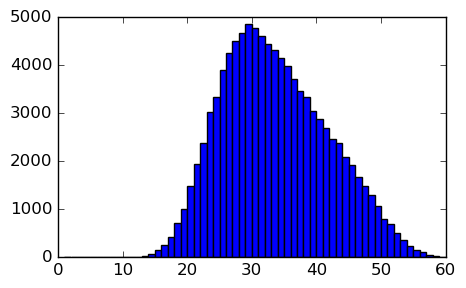

33.11988

In [68]:
repeated_hist(SC, bins=1:60)

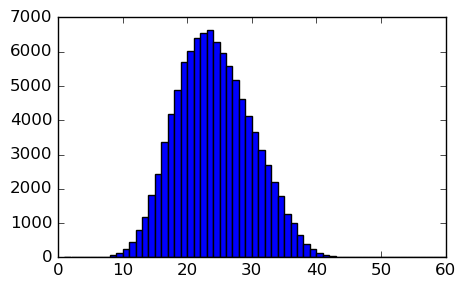

23.71233

In [69]:
repeated_hist(KT, bins=1:60)

The next two players have bi-modal distributions; some games they score a lot, some games not:

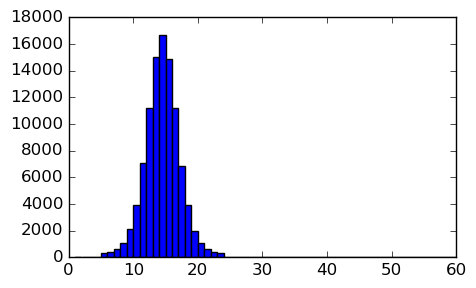

13.99319

In [70]:
repeated_hist(DG, bins=1:60)

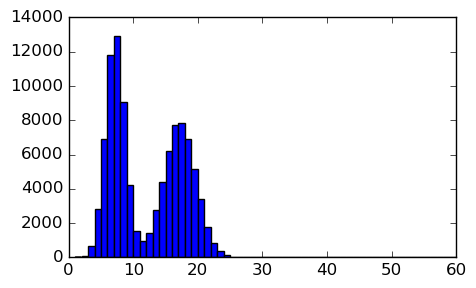

11.69675

In [71]:
repeated_hist(HB, bins=1:60)

The fifth "player" (actually the sum of all the other players on the team) looks like this:

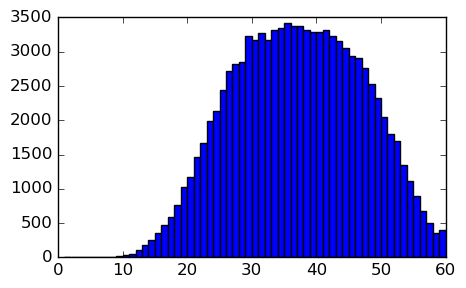

36.68018

In [72]:
repeated_hist(OT, bins=1:60)

Now we define the team score to be the sum of the five players, and look at the distribution:

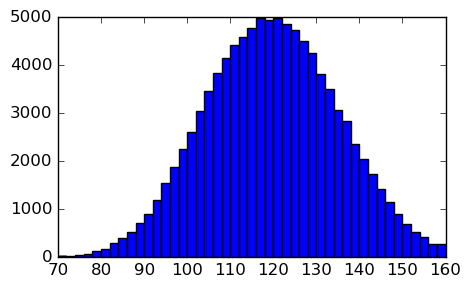

119.20473

In [73]:
GSW()= SC() + KT() + DG() + HB() + OT()

repeated_hist(GSW, bins=70:2:160)

Sure enough, this looks very much like a normal distribution. The Central Limit Theorem appears to hold in this case. But I have to say "Central Limit" is not a very evocative name, so I propose we re-name this as the **Strength in Numbers Theorem**, to indicate the fact that if you have a lot of numbers, you tend to get the expected result.

# Conclusion

We've had an interesting tour and met some giants of the field: Laplace, Bernoulli, Fermat, Pascal, Bayes, Newton, ... even Mr. Monopoly and The Count.

![The Count](http://img2.oncoloring.com/count-dracula-number-thir_518b77b54ba6c-p.gif)
<center><a href="https://en.wikipedia.org/wiki/Count_von_Count">The Count</a><br>1972&mdash;</center>

The conclusion is: be explicit about what the problem says, and then methodical about defining the sample space, and finally be careful in counting the number of outcomes in the numerator and denominator. Easy as 1-2-3. 

<hr>

# Appendix: Continuous Sample Spaces

Everything up to here has been about discrete, finite sample spaces, where we can *enumerate* all the possible outcomes. 

But I was asked about *continuous* sample spaces, such as the space of real numbers. The principles are the same: probability is still the ratio of the favorable cases to all the cases, but now instead of *counting* cases, we have to (in general) compute integrals to compare the sizes of cases. 
Here we will cover a simple example, which we first solve approximately by simulation, and then exactly by calculation.

## The Hot New Game Show Problem: Simulation

Oliver Roeder posed [this problem](http://fivethirtyeight.com/features/can-you-win-this-hot-new-game-show/) in the 538 *Riddler* blog:

>Two players go on a hot new game show called *Higher Number Wins.* The two go into separate booths, and each presses a button, and a random number between zero and one appears on a screen. (At this point, neither knows the other’s number, but they do know the numbers are chosen from a standard uniform distribution.) They can choose to keep that first number, or to press the button again to discard the first number and get a second random number, which they must keep. Then, they come out of their booths and see the final number for each player on the wall. The lavish grand prize — a case full of gold bullion — is awarded to the player who kept the higher number. Which number is the optimal cutoff for players to discard their first number and choose another? Put another way, within which range should they choose to keep the first number, and within which range should they reject it and try their luck with a second number?

We'll use this notation:
- **A**, **B**: the two players.
- *A*, *B*: the cutoff values they choose: the lower bound of the range of first numbers they will accept.
- *a*, *b*: the actual random numbers that appear on the screen.

For example, if player **A** chooses a cutoff of *A* = 0.6, that means that **A** would accept any first number greater than 0.6, and reject any number below that cutoff. The question is: What cutoff, *A*, should player **A** choose to maximize the chance of winning, that is, maximize P(*a* > *b*)?

First, simulate the number that a player with a given cutoff gets (note that `rand()` returns a float sampled uniformly from the interval [0,1)):

In [74]:
"Play the game with given cutoff, returning the first or second random number."
function number(cutoff)
    first = rand()
    ifelse(first > cutoff, first, rand())
end

number

In [75]:
number(.5)

0.8985568350187598

Now compare the numbers returned with a cutoff of *A* versus a cutoff of *B*, and repeat for a large number of trials; this gives us an estimate of the probability that cutoff *A* is better than cutoff *B*:

In [76]:
"The probability that cutoff A wins against cutoff B."
function Pwin(A, B, trials=30000)
    Awins = sum(number(A) > number(B) 
                for _ in 1:trials)
    Awins / trials
end

Pwin

In [77]:
Pwin(.5, .6)

0.4946

Now define a function, `top`, that considers a collection of possible cutoffs, estimate the probability for each cutoff playing against each other cutoff, and returns a list with the `N` top cutoffs (the ones that defeated the most number of opponent cutoffs), and the number of opponents they defeat: 

In [78]:
using DataStructures # For the counter function 
"Return the N best cutoffs and the number of opponent cutoffs they beat."
function top(N, cutoffs,Pcalc=Pwin)
    winners = counter([ifelse(Pcalc(A, B) > 0.5,A, B) for (A, B) in combinations(cutoffs, 2)])
    select(collect(winners.map), 1:N, by=p->p[2], rev=true)
end

top

In [79]:
@time top(5, 0.50:0.01:0.99)

  0.885991 seconds (325.12 k allocations: 14.411 MB)


5-element Array{Pair{Float64,Int64},1}:
 0.59=>46
 0.58=>45
 0.6=>44 
 0.61=>43
 0.56=>43

We get a good idea of the top cutoffs, but they are close to each other, so we can't quite be sure which is best, only that the best is somewhere around 0.60. We could get a better estimate by increasing the number of trials.

## The Hot New Game Show Problem: Exact Calculation

More promising is the possibility of making `Pwin(A, B)` an exact calculation. But before we get to `Pwin(A, B)`, let's solve a simpler problem: assume that both players **A** and **B** have chosen a cutoff, and have each received a number above the cutoff. What is the probability that **A** gets the higher number? We'll call this `Phigher(A, B)`. We can think of this as a two-dimensional sample space of points in the (*a*, *b*) plane, where *a* ranges from the cutoff *A* to 1 and *b* ranges from the cutoff B to 1. Here is a diagram of that two-dimensional sample space, with the cutoffs *A*=0.5 and *B*=0.6:

<img src="http://norvig.com/ipython/probability2da.jpg" width=413>

The total area of the sample space is 0.5 &times; 0.4 = 0.20, and in general it is (1 - *A*) &middot; (1 - *B*). What about the favorable cases, where **A** beats **B**? That corresponds to the shaded triangle below:

<img src="http://norvig.com/ipython/probability2d.jpg" width=413>

The area of a triangle is 1/2 the base times the height, or in this case, 0.4<sup>2</sup> / 2 = 0.08, and in general, (1 - *B*)<sup>2</sup> / 2. So in general we have:

    Phigher(A, B) = favorable / total
    favorable     = ((1 - B)^2) / 2 
    total         = (1 - A) * (1 - B)
    Phigher(A, B) = (((1 - B) ^ 2) / 2) / ((1 - A) * (1 - B))
    Phigher(A, B) = (1 - B) / (2 * (1 - A))
    
And in this specific case we have:

     A = 0.5; B = 0.6
     favorable         = 0.4 ^ 2 / 2 = 0.08
     total             = 0.5 * 0.4    = 0.20
     Phigher(0.5, 0.6) = 0.08 / 0.20  = 0.4

But note that this only works when the cutoff *A* &le; *B*; when *A* > *B*, we need to reverse things. That gives us the code:

In [80]:
"Probability that a sample from [A..1] is higher than one from [B..1]."
function Phigher(A, B)
    if A <= B
        return (1 - B) / (2 * (1 - A))
    else
        return(1 - Phigher(B, A))
    end
end

Phigher

In [81]:
Phigher(0.5, 0.6)

0.4

We're now ready to tackle the full game. There are four cases to consider, depending on whether **A** and **B** gets a first number that is above or below their cutoff choices:

| first *a* | first *b* | P(*a*, *b*) | P(A wins &vert; *a*, *b*) |  Comment |
|:-----:|:-----:| ----------- | ------------- | ------------ |
| *a* > *A* | *b* > *B* | (1 - *A*) &middot; (1 - *B*) | Phigher(*A*, *B*) | Both above cutoff; both keep first numbers |
| *a* < *A* | *b* < *B* | *A* &middot; *B* | Phigher(0, 0)  | Both below cutoff, both get new numbers from [0..1] |
| *a* > *A* | *b* < *B* | (1 - *A*) &middot;  *B* | Phigher(*A*, 0) | **A** keeps number; **B** gets new number from [0..1] |
| *a* < *A* | *b* > *B* | *A* &middot; (1 - *B*) | Phigher(0, *B*) | **A** gets new number from [0..1]; **B** keeps number |

For example, the first row of this table says that the event of both first numbers being above their respective cutoffs has probability (1 - *A*) &middot; (1 - *B*), and if this does occur, then the probability of **A** winning is Phigher(*A*, *B*).
We're ready to replace the old simulation-based `Pwin` with a new calculation-based version:

In [82]:
"With what probability does cutoff A win against cutoff B?"
function Pwin_exact(A, B)
    return ((1-A) * (1-B) * Phigher(A, B)  # both above cutoff
            + A * B       * Phigher(0, 0)  # both below cutoff
            + (1-A) * B   * Phigher(A, 0)  # A above, B below
            + A * (1-B)   * Phigher(0, B)) # A below, B above
end

Pwin_exact

That was a lot of algebra. Let's define a few tests to check for obvious errors:

In [83]:
function test()
    @assert Phigher(0.5, 0.5) == Phigher(0.7, 0.7) == Phigher(0, 0) == 0.5
    @assert Pwin_exact(0.5, 0.5) == Pwin_exact(0.7, 0.7) == 0.5
    @assert Phigher(.6, .5) == 0.6
    @assert Phigher(.5, .6) == 0.4
    "ok"
end

test()

"ok"

Let's repeat the calculation with our new, exact `Pwin`:

In [84]:
top(5, 0.50:0.01:0.99, Pwin_exact)

5-element Array{Pair{Float64,Int64},1}:
 0.62=>49
 0.61=>48
 0.6=>47 
 0.59=>46
 0.63=>45

It is good to see that the simulation and the exact calculation are in rough agreement; that gives me more confidence in both of them. We see here that 0.62 defeats all the other cutoffs, and 0.61 defeats all cutoffs except 0.62. The great thing about the exact calculation code is that it runs fast, regardless of how much accuracy we want. We can zero in on the range around 0.6:

In [85]:
top(10, 0.500:0.001:0.700, Pwin_exact)

10-element Array{Pair{Float64,Int64},1}:
 0.618=>200
 0.617=>199
 0.616=>198
 0.619=>197
 0.615=>196
 0.614=>195
 0.613=>194
 0.62=>193 
 0.612=>192
 0.611=>191

This says 0.618 is best, better than 0.620. We can get even more accuracy:

In [86]:
top(5, 0.61700:0.00001:0.61900,Pwin_exact)

5-element Array{Pair{Float64,Int64},1}:
 0.61803=>200
 0.61802=>199
 0.61804=>198
 0.61801=>197
 0.618=>196  

So 0.61803 is best. Does that number [look familiar](https://en.wikipedia.org/wiki/Golden_ratio)? Can you prove that it is what I think it is?

To understand the strategic possibilities, it is helpful to draw a 3D plot of `Pwin(A, B)` for values of *A* and *B* between 0 and 1:

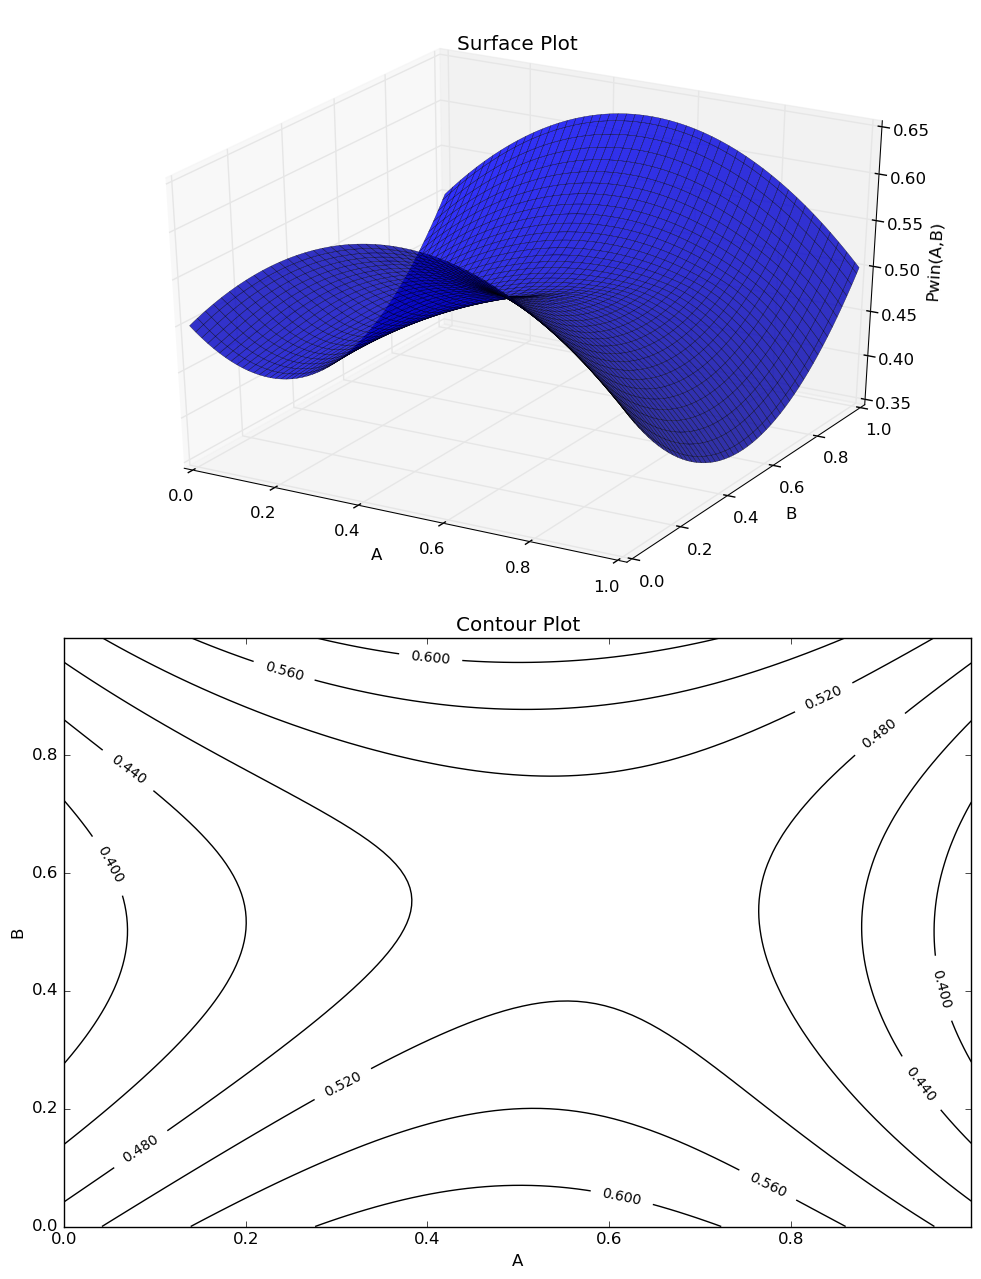

In [87]:
fig=figure("Pringle",figsize=(10,13))
ax = fig[:add_subplot](2,1,1, projection = "3d")

cutoffs=linspace(0.0,0.999,100)

A_grid=repmat(cutoffs',length(cutoffs),1)
B_grid=repmat(cutoffs,1,length(cutoffs))

z=[Pwin_exact(A,B) for B in cutoffs, A in cutoffs] #The surface 
ax[:plot_surface](A_grid,B_grid,z,rstride=2,edgecolors="k", cstride=2,  alpha=0.8, linewidth=0.25)
ax[:set_xlabel]("A")
ax[:set_ylabel]("B")
ax[:set_zlabel]("Pwin(A,B)")
title("Surface Plot")

#subplot(212)
ax = fig[:add_subplot](2,1,2)
cp = ax[:contour](A_grid, B_grid, z, colors="black", linewidth=2.0)
ax[:clabel](cp, inline=1, fontsize=10)
xlabel("A")
ylabel("B")
title("Contour Plot")
tight_layout()

What does this [Pringle of Probability](http://fivethirtyeight.com/features/should-you-shoot-free-throws-underhand/) show us? The highest win percentage for **A**, the peak of the surface, occurs when *A* is around 0.5 and *B* is 0 or 1. We can confirm that, finding the maximum `Pwin(A, B)` for many different cutoff values of `A` and `B`:

In [88]:
cutoffs = union(Set(collect(0.0:0.01:1.0-0.01)),Set(collect(0.5:0.001:0.7)),Set(collect(0.61700:0.00001:0.61900)))

Set([0.61836,0.61826,0.61867,0.558,0.61728,0.61854,0.61809,0.22,0.653,0.61719  …  0.585,0.21,0.53,0.03,0.52,0.61817,0.17,0.41,0.614,0.61871])

In [89]:
maximum((Pwin_exact(A, B), A, B)
    for A in cutoffs for B in cutoffs)

(0.625,0.5,0.0)

So **A** could win 62.5% of the time if only **B** would chose a cutoff of 0. But, unfortunately for **A**, a rational player **B** is not going to do that. We can ask what happens if the game is changed so that player **A** has to declare a cutoff first, and then player **B** gets to respond with a cutoff, with full knowledge of **A**'s choice. In other words, what cutoff should **A** choose to maximize `Pwin(A, B)`, given that **B** is going to take that knowledge and pick a cutoff that minimizes `Pwin(A, B)`? 

In [90]:
maximum(minimum((Pwin_exact(A, B), A, B) for B in cutoffs)
    for A in cutoffs)

(0.5,0.61803,0.61803)

And what if we run it the other way around, where **B** chooses a cutoff first, and then **A** responds?

In [91]:
minimum(maximum((Pwin_exact(A, B), A, B) for A in cutoffs)
    for B in cutoffs)

(0.5,0.61803,0.61803)

In both cases, the rational choice for both players in a cutoff of 0.61803, which corresponds to the  "saddle point" in the middle of the plot. This is a *stable equilibrium*; consider fixing *B* = 0.61803, and notice that if *A* changes to any other value, we slip off the saddle to the right or left, resulting in a worse win probability for **A**. Similarly, if we fix *A* = 0.61803, then if *B* changes to another value, we ride up the saddle to a higher win percentage for **A**, which is worse for **B**. So neither player will want to move from the saddle point.

The moral for continuous spaces is the same as for discrete spaces: be careful about defining your space; count/measure carefully, and let your code take care of the rest.